In [133]:
import warnings 
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score
from sklearn.pipeline import Pipeline


from dependencies.plots import plot_confusion_matrix

In [130]:
DATA_RAW_PATH = os.path.join('..','data','raw')
DATA_PROCE_TRAIN_NAME = 'df_train.csv'
DATA_PROCE_VALID_NAME = 'df_test.csv'
DATA_VALID_NAME = 'submission.csv'
DATA_INTER_PATH = os.path.join('..','data','interim')
DATA_INTER_PROCESSED = os.path.join('..', 'data', 'processed')
IMG_PATH = os.path.abspath(os.path.join('..','reports', 'figures'))

In [36]:
df_train = pd.read_csv(os.path.join(DATA_INTER_PROCESSED, DATA_PROCE_TRAIN_NAME))
df_valid = pd.read_csv(os.path.join(DATA_INTER_PROCESSED, DATA_PROCE_VALID_NAME))

In [84]:
X = df_train.drop(columns=['inadimplente'])
y = df_train['inadimplente']

In [86]:
y.value_counts()

0    71363
1     5123
Name: inadimplente, dtype: int64

In [87]:
#Balanceamento

over = SMOTE(sampling_strategy = 'minority')

In [88]:
X_smote, y_smote = over.fit_resample(X, y)

In [89]:
y_smote.value_counts()

1    71363
0    71363
Name: inadimplente, dtype: int64

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3, random_state=334)

In [92]:
gbc = GradientBoostingClassifier(learning_rate=0.5, max_depth=10, max_features=0.71,
                               min_samples_leaf=9, min_samples_split=16, n_estimators=100, subsample=0.85)

In [112]:
gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)

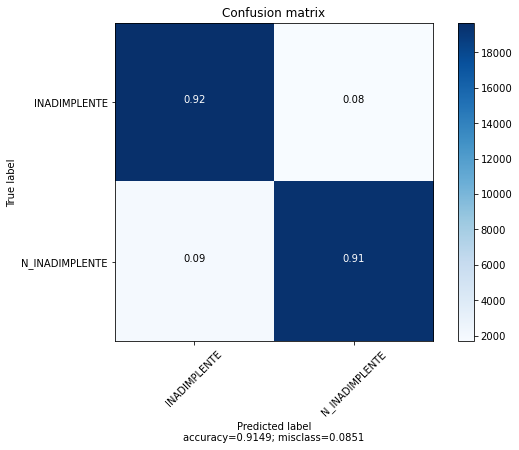

In [115]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['INADIMPLENTE', 'N_INADIMPLENTE'])

In [116]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92     21354
           1       0.92      0.91      0.91     21464

    accuracy                           0.91     42818
   macro avg       0.91      0.91      0.91     42818
weighted avg       0.92      0.91      0.91     42818



In [123]:
modelo_pipe  =  Pipeline(steps = [('model', gbc)])

In [124]:
cross_validation_results = cross_val_score(modelo_pipe, X_smote, y_smote, scoring = 'recall')
print(f'A média de validação cruzada foi: {round(np.mean(cross_validation_results),2)}\nO desvio padrão de validação cruzada foi: {round(np.std(cross_validation_results),2)}')

A média de validação cruzada foi: 0.9
O desvio padrão de validação cruzada foi: 0.07


## Aplicação do modelo no df_test

In [128]:
y_pred = gbc.predict(df_valid)
df_valid['inadimplente'] = y_pred
df_valid.head()

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes,inadimplente
0,0.025849,62,0,0.081775,8180.0,3,0,2,0,0.0,0
1,0.667083,55,0,0.153112,2200.0,3,0,0,0,0.0,1
2,0.007093,44,0,0.148800,7499.0,20,0,1,0,0.0,0
3,0.091213,54,0,0.351635,5900.0,15,0,1,1,0.0,0
4,0.112680,54,0,0.065959,2167.0,3,0,0,0,0.0,1


In [132]:
df_valid.to_csv(os.path.join(DATA_INTER_PROCESSED, DATA_VALID_NAME), index=False)

## Considerações

* A análise do modelo foi baseada no recall, pois os Falsos Negativos (pessoas que o modelo disse não são inadimplentes, mas que na verdade são) parecem ser mais danosos para a empresa.
* O modelo mostrou-se muito eficaz para a previsão do target, tanto nos dados de treino como nos dados de teste, trazendo um precision, recall e f1-score satisfatório.